In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output

import math
from scipy import integrate

In [25]:
class tank_:
    def __init__(self):
        self.a = 2.9 # ширина, м
        self.b = 2.2 # высота, м
        self.type = '100' # тип танковой пушки
        self.n = 15 # скорострельность, 1/м
        self.omega = 1.7 # среднее число попаданий, необходимое для поражения цели
        self.V = 12 # скорость танка, м/с
        self.Ex_x = 1/1300

class test_:
    def __init__(self):
        self.a = 2.2 # ширина, м
        self.b = 3 # высота, м
        self.type = '100' # тип танковой пушки
        self.n = 14 # скорострельность, 1/м
        self.omega = 1.3 # среднее число попаданий, необходимое для поражения цели
        self.V = 14 # скорость танка, м/с
        self.Ex_x = 1/800

class ATS_:
    def __init__(self):
        self.a = 1.8 # ширина, м
        self.b = 2 # высота, м
        self.type = ['100', '152', 'ПТРК'] # типы пушек
        self.n = {  # скорострельность
            '100': 14,
            '152': 12,
            'ПТРК': ['сам', 'ком'][0]   }
        self.omega = {  # тип танковой пушки
            '100': 1.5,
            '152': 1.2,
            'ПТРК': 1.3
        }
        self.V = 160 # скорость ПТУР, м/c
        self.Ex_x = {
            '100': 1/1500,
            '152': 1/900,
            'ПТРК': 1/1500
        }

class figth_:
    def __init__(self, tank, ATS):
        self.tank = tank
        self.ATS = ATS
        self.x = 900
        self.t = 0
        self.sigma = 0

        self.table_tank = pd.DataFrame({
            't': [],
            'X': [],
            'sigma': [],
            'Ф_b': [],
            'Ф_а': [],
            'W': []     
            })
        
        self.table_ATS = pd.DataFrame({
            't': [],
            'X': [],
            'sigma_100': [],
            'sigma_152': [],
            'Ф_b_100': [],
            'Ф_a_100': [],
            'Ф_b_152': [],
            'Ф_а_152': [],
            'W_100': [],
            'W_152': []     
            })
    
    def get_F(self, x):
        def f(t):
            return math.exp(-t**2/2)
        part_1 = 1/math.sqrt(2*math.pi)
        part_2, err = integrate.quad(f, 0, x)
        return part_1*part_2

    def get_W_tank(self):
         return 4/self.tank.omega*self.F_a*self.F_b
    
    def get_W_ATS(self):
         return 4/self.tank.omega*self.F_a*self.F_b
    
    def calculate(self):
        # цикл по пушкам
        while self.x > 0:

            self.sigma = 1.48*self.tank.Ex_x*self.x

            self.F_a = self.get_F(self.ATS.a/(2*self.sigma))
            self.F_b = self.get_F(self.ATS.b/(2*self.sigma))

            self.W = self.get_W_tank()
            
            tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[self.x],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W]  })

            self.table_tank = pd.concat([self.table_tank, tmp_df], ignore_index = True)

            self.t += 60/tank.n
            self.x -= tank.V*60/tank.n

        self.x = 900
        while self.x > 0:
            
            self.sigma_100 = 1.48*self.ATS.Ex_x['100']*self.x
            self.sigma_152 = 1.48*self.ATS.Ex_x['152']*self.x

            self.F_a = self.get_F(self.tank.a/(2*self.sigma))
            self.F_b = self.get_F(self.tank.b/(2*self.sigma))

            self.W = self.get_W()
            
            tmp_df = pd.DataFrame({
                't': [self.t],
                'X':[self.x],
                'sigma': [self.sigma],
                'Ф_b': [self.F_b],
                'Ф_а': [self.F_a],
                'W': [self.W]  })

            self.table_100 = pd.concat([self.table_100, tmp_df], ignore_index = True)

            self.t += 60/tank.n
            self.x -= tank.V*60/tank.n

    def plot(self):
        pass

tank = tank_()
ATS = ATS_()
test_tank = test_()
figth = figth_(test_tank, ATS)
figth.calculate()
print(1.48*figth.tank.Ex_x*900)
figth.table_tank

1.665


,t,X,sigma,Ф_b,Ф_а,W
0,0.0,900.0,1.6650,0.225947,0.205588,0.142929
1,4.0,852.0,1.5762,0.237102,0.215998,0.157580
2,8.0,804.0,1.4874,0.249308,0.227438,0.174468
3,12.0,756.0,1.3986,0.262696,0.240050,0.194031
4,16.0,708.0,1.3098,0.277410,0.253999,0.216806
5,20.0,660.0,1.2210,0.293607,0.269469,0.243440
6,24.0,612.0,1.1322,0.311446,0.286668,0.274712
7,28.0,564.0,1.0434,0.331071,0.305812,0.311524
8,32.0,516.0,0.9546,0.352579,0.327109,0.354867
9,36.0,468.0,0.8658,0.375955,0.350714,0.405701


(0.0, 1.0)

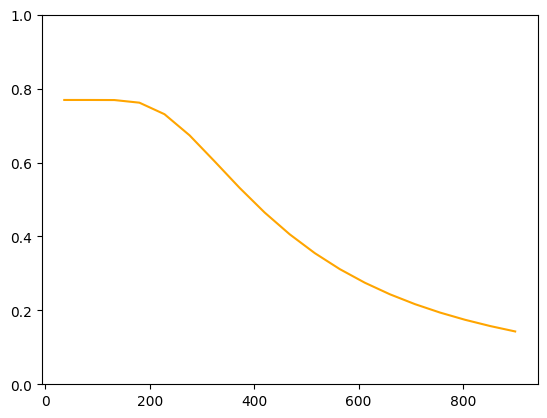

In [26]:
plt.plot(figth.table_tank.X, figth.table_tank.W, c='orange', label='100-мм, танк')
plt.legend
plt.ylim(0, 1)